In [3]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imagehash
import os

In [44]:
from PIL import Image
import imagehash
import os
import matplotlib.pyplot as plt

differences = []
path = '/home/beomseok/ppe_data/PPE_all/sim1.23a-part1/Frames'
imgdir = os.listdir(path)

hash_ref = imagehash.average_hash(Image.open(os.path.join(path, 'Sim1_above_100.png')))

# for img in imgdir:
#     hash = imagehash.average_hash(Image.open(os.path.join(path, img)))
#     difference = hash_ref - hash
#     if difference == 0:
#         continue
#     differences.append(difference)

aspect_ratio = 1920/1080
target_size = (100, int(100 / aspect_ratio))

n_samples = len(imgdir)
print(n_samples)
distance_matrix = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        hash1 = imagehash.average_hash(Image.open(os.path.join(path, imgdir[i])))
        hash2 = imagehash.average_hash(Image.open(os.path.join(path, imgdir[j])))
        distance_matrix[i][j] = hash1 - hash2
print(distance_matrix)
    
#!resizing and converting into grayscale doesn't improve the speed
#! It takes 150 minutes where num of samples are 300
# fig, ax = plt.subplots(figsize = (5, 5))
# ax.hist(differences, bins=len(differences), edgecolor="black")
# plt.show()



301
[[ 0. 13.  9. ...  8.  9.  9.]
 [13.  0.  8. ...  7.  8.  8.]
 [ 9.  8.  0. ...  5.  2.  6.]
 ...
 [ 8.  7.  5. ...  0.  5.  1.]
 [ 9.  8.  2. ...  5.  0.  6.]
 [ 9.  8.  6. ...  1.  6.  0.]]


## Compute Distance matrix using Image Hashing and Multithreading

In [112]:
print(n_samples)

301


In [111]:
from concurrent.futures import ThreadPoolExecutor, as_completed

n_samples = len(imgdir)
def compute_row(i):
    row = np.zeros(n_samples)
    for j in range(n_samples):
        hash1 = imagehash.average_hash(Image.open(os.path.join(path, imgdir[i])))
        hash2 = imagehash.average_hash(Image.open(os.path.join(path, imgdir[j])))
        row[j] = hash1 - hash2
    return row

distance_hash_matrix = np.zeros((n_samples, n_samples))
with ThreadPoolExecutor(max_workers=8) as executor:
    future_to_row = {executor.submit(compute_row, i): i for i in range(n_samples)}
    for future in as_completed(future_to_row):
        i = future_to_row[future]
        distance_hash_matrix[i] = future.result()

print(distance_hash_matrix)

[[ 0. 13.  9. ...  8.  9.  9.]
 [13.  0.  8. ...  7.  8.  8.]
 [ 9.  8.  0. ...  5.  2.  6.]
 ...
 [ 8.  7.  5. ...  0.  5.  1.]
 [ 9.  8.  2. ...  5.  0.  6.]
 [ 9.  8.  6. ...  1.  6.  0.]]


In [59]:
print(distance_hash_matrix.shape)

(301, 301)


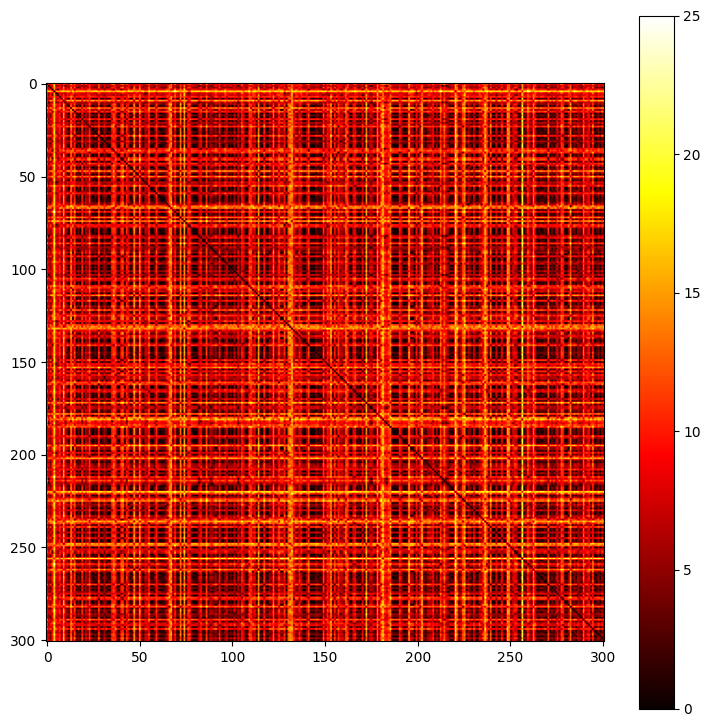

In [50]:
fig = plt.subplots(figsize = (9, 9))
plt.imshow(distance_hash_matrix, cmap='hot')
plt.colorbar()
plt.show()

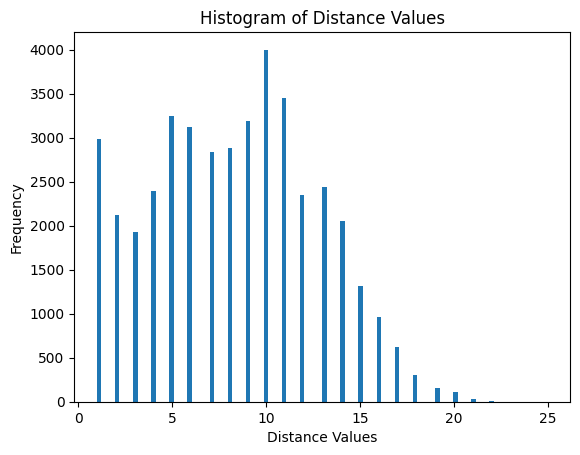

In [58]:
# Extract the upper triangular matrix
upper_triangular = np.triu(distance_hash_matrix)

# Flatten the matrix into a 1D array
distance_hash_values = upper_triangular[upper_triangular != 0].flatten()

# Plot the histogram
plt.hist(distance_hash_values, bins=100)
plt.xlabel('Distance Values')
plt.ylabel('Frequency')
plt.title('Histogram of Distance Values')
plt.show()

In [109]:
distance_hash_values.shape

(42490,)

In [110]:
from statistics import mean, variance
print(mean(distance_hash_values))
print(variance(distance_hash_values))

12.983388704318937
5.616389811738649


## Compute Distance Matrix using MSE without Image Hashing

In [122]:
import cv2

path = '/home/beomseok/ppe_data/PPE_all/sim1.23a-part1/Frames'

img_ref = cv2.imread(os.path.join(path, 'Sim1_above_2.png'))
img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2GRAY)

n_samples = len(imgdir)

def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return int(mse)

def compute_mse_row(i):
   row = np.zeros(n_samples)
   for j in range(n_samples):
      img1 = cv2.imread(os.path.join(path, imgdir[i]))
      img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
      img2 = cv2.imread(os.path.join(path, imgdir[j]))
      img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
      err = mse(img1, img2)
      row[j] = err
   return row

distance_mse_matrix = np.zeros((n_samples, n_samples))
with ThreadPoolExecutor(max_workers=8) as executor:
   future_to_row = {executor.submit(compute_mse_row, i): i for i in range(n_samples)}
   for future in as_completed(future_to_row):
      i = future_to_row[future]
      distance_mse_matrix[i] = future.result()

print(distance_mse_matrix)
print(distance_mse_matrix.shape)

[[ 0. 15. 30. ... 31. 24. 31.]
 [36.  0. 38. ... 36. 29. 37.]
 [42. 30.  0. ... 22. 15. 22.]
 ...
 [40. 27. 20. ...  0. 13.  9.]
 [49. 37. 29. ... 37.  0. 35.]
 [41. 29. 20. ...  9. 12.  0.]]
(301, 301)


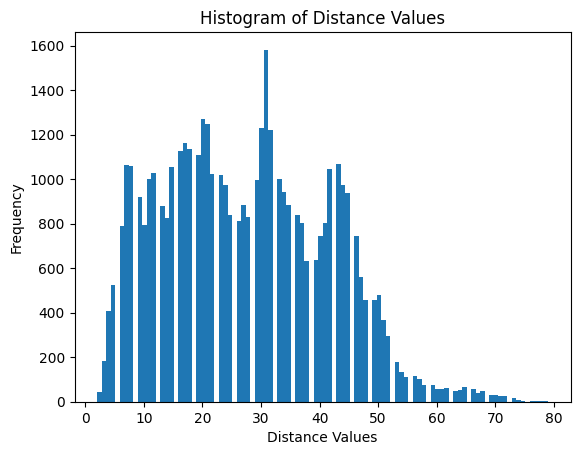

In [129]:
upper_triangular = np.triu(distance_mse_matrix)

# Flatten the matrix into a 1D array
distance_mse_values = upper_triangular[upper_triangular != 0].flatten()

# Plot the histogram
plt.hist(distance_mse_values, bins=100)
plt.xlabel('Distance Values')
plt.ylabel('Frequency')
plt.title('Histogram of Distance Values')
plt.show()

In [128]:
from statistics import mean, variance
print(mean(distance_mse_values))
print(variance(distance_mse_values))

27.43262458471761
196.4915401002616


## Discard algorithm implementation

In [ ]:
path = '/home/beomseok/ppe_data/sim-mask-incomplete/k=2,s=3/Frames'
imgdir = os.listdir(path)
distance_matrix = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        hash1 = imagehash.average_hash(Image.open(os.path.join(path, imgdir[i])))
        hash2 = imagehash.average_hash(Image.open(os.path.join(path, imgdir[j])))
        distance = hash1 - hash2
        if distance < 10:
            print()


In [15]:
path = '/home/beomseok/ppe_data/sim-mask-incomplete/k=2,s=3/Frames'

def sort_key(filename):
    parts = filename.split("_")
    suffix = parts[-1]
    num = int(suffix.split(".")[0])
    return num

files = os.listdir(path)
sorted_imgdir = sorted(files, key=sort_key)

In [1]:
def hash_diff(img1, img2):
    hash1 = imagehash.average_hash(Image.open(img1))
    hash2 = imagehash.average_hash(Image.open(img2))
    return hash1 - hash2

In [5]:
def sort_key(filename):
    parts = filename.split("_")
    suffix = parts[-1]
    num = int(suffix.split(".")[0])
    return num

def remove_frame(path, threshold, queue_size):

    files = os.listdir(path)
    sorted_imgdir = sorted(files, key=sort_key)

    check_point = queue_size
    end_state = False
 
    queue = sorted_imgdir[:check_point]
    while len(queue) >= 2 or end_state:
        print('---while loop iteration---')
        remove_list = []
        count = 0
        for i in range(1, len(queue)):
            img_ref = os.path.join(path, queue[0])
            print('for loop iteration',i)
            img = os.path.join(path, queue[i])
            diff = hash_diff(img_ref, img)
            print('difference btween {} and {} is'.format(queue[0][37:], queue[i][37:]), diff)
            if diff <= threshold:
                print(queue[i], 'will be removed')
                remove_list.append(queue[i])
                count +=1
        print('remove list:',remove_list)
        for tbr in remove_list:
            os.remove(os.path.join(path, tbr)) #By commenting this out this code will remove your files 
            queue.remove(tbr)
        queue.pop(0)
        print("after removing the 1st eleement and elements in the remove list, the queue length is ", len(queue))

        if end_state:
            pass
        
        else:            
            queue.extend(sorted_imgdir[check_point:check_point + count+1])
            if len(queue) <= 2:
                print("you reach the last two elements and queue won't be loaded")
                end_state = False
            else:
                print('queue is loaded with the next elements and its size is ', len(queue))
                print(queue)
                check_point+=count+1
                print('check point: ', check_point)

path = '/home/beomseok/ppe_data/sim-mask-incomplete/k=2,s=3/Frames'
remove_frame(path, threshold=2, queue_size=3)
    


---while loop iteration---
for loop iteration 1
difference btween d_above_0.png and d_above_1.png is 5
for loop iteration 2
difference btween d_above_0.png and d_above_2.png is 6
remove list: []
after removing the 1st eleement and elements in the remove list, the queue length is  2
queue is loaded with the next elements and its size is  3
['mask incomplete sim-trauma 1 above bed_above_1.png', 'mask incomplete sim-trauma 1 above bed_above_2.png', 'mask incomplete sim-trauma 1 above bed_above_3.png']
check point:  4
---while loop iteration---
for loop iteration 1
difference btween d_above_1.png and d_above_2.png is 5
for loop iteration 2
difference btween d_above_1.png and d_above_3.png is 5
remove list: []
after removing the 1st eleement and elements in the remove list, the queue length is  2
queue is loaded with the next elements and its size is  3
['mask incomplete sim-trauma 1 above bed_above_2.png', 'mask incomplete sim-trauma 1 above bed_above_3.png', 'mask incomplete sim-trauma 1 

## Discard Algorithm Statistics

In [4]:
def sort_key(filename):
    parts = filename.split("_")
    suffix = parts[-1]
    num = int(suffix.split(".")[0])
    return num

def hash_diff(img1, img2):
    hash1 = imagehash.average_hash(Image.open(img1))
    hash2 = imagehash.average_hash(Image.open(img2))
    return hash1 - hash2
    
def stat_frame(imgdir, queue_size):

    files = os.listdir(path)
    sorted_imgdir = sorted(files, key=sort_key)

    check_point = queue_size
    end_state = False
 
    matrix_profile = np.zeros((len(files) - queue_size-1, queue_size-1))
    for i in range(matrix_profile.shape[0]):
        queue = sorted_imgdir[i:check_point+i]
        row = np.zeros(queue_size-1)
        for j in range(1, len(queue)):
            img_ref = os.path.join(path, queue[0])
            img = os.path.join(path, queue[j])
            diff = hash_diff(img_ref, img)
            # print('difference btween {} and {} is'.format(queue[0][37:], queue[j][37:]), diff)
            row[j-1] = diff 
        # print(row)
        matrix_profile[i] = row
        # queue = sorted_imgdir[i:check_point+i]
    return matrix_profile

path = '/home/beomseok/ppe_data/PPE_all/sim3/Frames'
matrix_profile = stat_frame(path, queue_size=3)
print(matrix_profile)

[[4. 2.]
 [2. 2.]
 [0. 0.]
 ...
 [4. 8.]
 [6. 9.]
 [9. 8.]]


In [10]:
import collections
def matrix_to_ordict(mat):
    frequency_dict = {}

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if mat[i][j] in frequency_dict:
                frequency_dict[mat[i][j]] += 1
            else:
                frequency_dict[mat[i][j]] = 0
    od = collections.OrderedDict(sorted(frequency_dict.items()))
    return(od)

print(matrix_to_ordict(matrix_profile))

OrderedDict([(0.0, 115), (1.0, 178), (2.0, 197), (3.0, 151), (4.0, 139), (5.0, 95), (6.0, 61), (7.0, 45), (8.0, 30), (9.0, 20), (10.0, 12), (11.0, 11), (12.0, 0), (13.0, 1), (14.0, 2)])


In [313]:
print(matrix_profile.shape)
print(len(imgdir))

(534, 4)
540


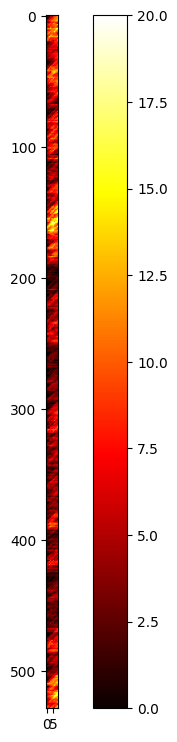

In [277]:
fig = plt.subplots(figsize = (9, 9))
plt.imshow(matrix_profile, cmap='hot')
plt.colorbar()
plt.show()

In [12]:
mean_column = matrix_profile.mean(0)
mean_column

array([2.81156716, 3.80037313])

In [294]:
(matrix_profile.ravel()).mean(0)

4.012172284644195

In [296]:
np.var((matrix_profile.ravel()))

8.468016629494032

14


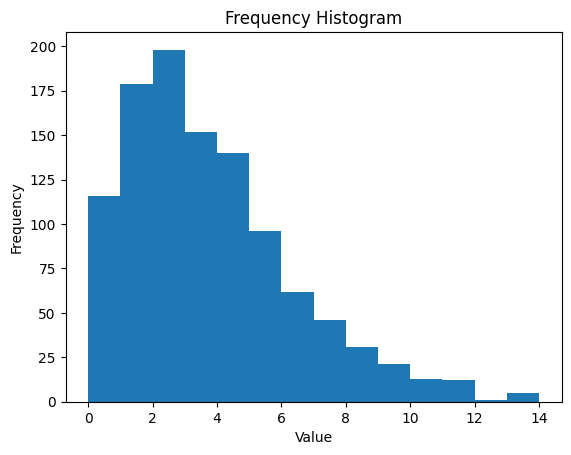

In [11]:
max_val = int(np.max(matrix_profile))
print(max_val)
plt.hist(matrix_profile.ravel(), bins=max_val, range=[0, max_val])
plt.title("Frequency Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [272]:
for i in range(1, 10):
    img = os.path.join(path, 'ppe sim 3 - trauma 1 above bed_above_{}.png'.format(1))
    img_ref = os.path.join(path, 'ppe sim 3 - trauma 1 above bed_above_{}.png'.format(1+i))
    diff = hash_diff(img_ref, img)
    print(diff)

2
2
2
6
5
9
10
11
13
